# Zillow Time Series Using Facebook Prophet

In [1]:
#Exploratory 
import pandas as pd
import numpy as np

#Data Visualization 
import seaborn as sns
import folium

#Data Modeling / Forecasting 
from statsmodels.tsa.arima_model import ARMA
import statsmodels.api as sm
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, plot_components_plotly

#Data Evaluation 
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Ignore any warnings
import warnings;
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import logging
logging.getLogger('fbprophet').setLevel(logging.WARNING)


# Step 1: Load the Data/Filtering for Chosen City

In [2]:
# import data
df = pd.read_csv('Data/zillow_metro_areas.csv')

In [3]:
df.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,...,2020-12-31,2021-01-31,2021-02-28,2021-03-31,2021-04-30,2021-05-31,2021-06-30,2021-07-31,2021-08-31,2021-09-30
0,102001,0,United States,Country,NaN,127569.0,127914.0,128277.0,129016.0,129762.0,...,269165.0,272132.0,275247.0,278593.0,282335.0,286913.0,292304.0,298069.0,303296.0,308220.0
1,394913,1,"New York, NY",Msa,NY,225438.0,226785.0,227997.0,230383.0,232604.0,...,514350.0,519193.0,523962.0,528241.0,532983.0,538439.0,545638.0,553551.0,561136.0,567059.0
2,753899,2,"Los Angeles-Long Beach-Anaheim, CA",Msa,CA,231209.0,232014.0,233247.0,235592.0,238105.0,...,736123.0,741232.0,748830.0,756443.0,767598.0,783132.0,803315.0,824025.0,837548.0,846526.0
3,394463,3,"Chicago, IL",Msa,IL,170602.0,171004.0,171525.0,172568.0,173673.0,...,257432.0,258905.0,261216.0,263319.0,266367.0,269105.0,272894.0,277086.0,281183.0,284285.0
4,394514,4,"Dallas-Fort Worth, TX",Msa,TX,130189.0,130293.0,130379.0,130591.0,130813.0,...,274646.0,276926.0,280361.0,284368.0,289886.0,296250.0,303499.0,311268.0,319368.0,326597.0


## Focus on New York State


In [4]:
# Overwrite dataframe to have NY state only
df = df[df['StateName']=='NY']
#Check for missing values
df.isnull().sum()

RegionID      0
SizeRank      0
RegionName    0
RegionType    0
StateName     0
             ..
2021-05-31    1
2021-06-30    0
2021-07-31    0
2021-08-31    0
2021-09-30    0
Length: 266, dtype: int64

In [5]:
# Fill missing values with backfilling 
df.fillna(method='bfill', inplace=True)

In [6]:
# See Regions
df['RegionName'].value_counts()

Corning, NY         1
Buffalo, NY         1
Kingston, NY        1
Albany, NY          1
Rochester, NY       1
Glens Falls, NY     1
Elmira, NY          1
Ithaca, NY          1
Plattsburgh, NY     1
Hudson, NY          1
Oneonta, NY         1
Ogdensburg, NY      1
Cortland, NY        1
Syracuse, NY        1
Gloversville, NY    1
Amsterdam, NY       1
Utica, NY           1
New York, NY        1
Auburn, NY          1
Watertown, NY       1
Olean, NY           1
Binghamton, NY      1
Seneca Falls, NY    1
Malone, NY          1
Jamestown, NY       1
Batavia, NY         1
Name: RegionName, dtype: int64

# Data Preprocessing

### Creating Statistical Columns

- Create ROI, Standard Deviation and Mean

In [7]:
#Calculate ROI percentage

#df['ROI']= ( (df['2021-09-30']/df['2000-01-31'])-1 ) *100 
#or
df['ROI']= (  (df['2021-09-30']-df['2000-01-31'])/df['2000-01-31'] ) *100 

#Calculate standard deviation of monthly values
df['std']=df.loc[:,'2000-01-31':'2021-09-30'].std(skipna=True, axis=1)

#Calculate historical mean value
df['mean']=df.loc[:,'2000-01-31':'2021-09-30'].mean(skipna=True, axis=1)


In [8]:
# Show the first 5 rows of the new data
df[['std','mean','ROI']].head()

,std,mean,ROI
1,72598.360721,409101.000000,151.536564
47,27231.708154,131874.750958,140.335008
51,17954.160376,131403.904215,92.857426
60,30773.612628,176286.505747,129.552385
79,18868.807739,122148.214559,113.232829


## Reshape from Wide to Long Format

In [9]:
#cleaning melted dataFrame column RegionName
df['RegionName'] = df['RegionName'].apply(lambda x: x[:-4] )
df.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,...,2021-03-31,2021-04-30,2021-05-31,2021-06-30,2021-07-31,2021-08-31,2021-09-30,ROI,std,mean
1,394913,1,New York,Msa,NY,225438.0,226785.0,227997.0,230383.0,232604.0,...,528241.0,532983.0,538439.0,545638.0,553551.0,561136.0,567059.0,151.536564,72598.360721,409101.000000
47,394425,47,Buffalo,Msa,NY,93968.0,94487.0,94871.0,95602.0,96126.0,...,201195.0,203599.0,184705.0,214992.0,221501.0,224418.0,225838.0,140.335008,27231.708154,131874.750958
51,395031,51,Rochester,Msa,NY,100972.0,100678.0,100670.0,100915.0,101426.0,...,178740.0,181365.0,184705.0,188451.0,192158.0,194050.0,194732.0,92.857426,17954.160376,131403.904215
60,394308,60,Albany,Msa,NY,108218.0,108769.0,109063.0,109786.0,110293.0,...,230181.0,232777.0,234700.0,238043.0,241724.0,245616.0,248417.0,129.552385,30773.612628,176286.505747
79,395143,79,Syracuse,Msa,NY,83512.0,83785.0,84042.0,84537.0,85003.0,...,165917.0,167891.0,169984.0,172904.0,175277.0,177040.0,178075.0,113.232829,18868.807739,122148.214559


In [10]:
#Drop columns we dont need
df.drop(['RegionID', 'SizeRank'], axis=1,inplace=True)

In [11]:
# Melt function takes in the long shape dataFrame and returns a short shape dataFrame

def melt_data(df):
    melted = pd.melt(df, id_vars=['RegionName','RegionType', 'StateName','ROI','std','mean'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted

In [12]:
df_melted = melt_data(df)

### Sorting by hightest ROI by Exploratory Data Analysis

In [13]:
#From 2000
top_10_metro = df_melted.loc[df_melted.groupby("RegionName")["ROI"].\
              idxmax()].sort_values('ROI',
                                    ascending=False)[:10]
top_10_metro.reset_index(drop = 1)


,RegionName,RegionType,StateName,ROI,std,mean,time,value
0,Oneonta,Msa,NY,225.067117,31029.180385,113908.344828,2000-01-31,52148.0
1,Hudson,Msa,NY,222.014939,47299.592446,205821.812261,2000-01-31,107100.0
2,Watertown,Msa,NY,206.661853,31556.915271,114905.555556,2000-01-31,54009.0
3,Kingston,Msa,NY,188.390130,42602.158350,216531.574713,2000-01-31,121457.0
4,Glens Falls,Msa,NY,178.696213,33692.281393,151282.122605,2000-01-31,81455.0
5,Gloversville,Msa,NY,177.816183,19424.100888,92593.141762,2000-01-31,52944.0
6,Ithaca,Msa,NY,162.540068,42278.707190,175432.701149,2000-01-31,95462.0
7,New York,Msa,NY,151.536564,72598.360721,409101.000000,2000-01-31,225438.0
8,Cortland,Msa,NY,149.174048,20959.362905,100346.831418,2000-01-31,58478.0
9,Malone,Msa,NY,146.809470,17181.668402,86748.107280,2000-01-31,51026.0


# Facebook Prophet

- Utica
- Binghamton 
- Jamestown
- Syracuse
- Albany

### Let's write the functions to forecast 1 year into the future and return the ROI percentage 
- Facebook forecast:

In [14]:
def Facebook(city):
    """ 
    Takes a city and melts it into a dataframe:
    returns the Facebook forecasts plots
    """
    #Melting city
    city_df = df[df['RegionName'] == city]
    city_melted = melt_data(city_df)
    
    #Facebook df with ds for time and y for value
    city_melted['ds']= city_melted['time']
    city_melted['y']= city_melted['value']
    city_melted = city_melted[['ds','y']].reset_index()
    
    #instantiate
    prophet_model = Prophet()
    prophet_model.fit(city_melted)
    #forecast on future
    future = prophet_model.make_future_dataframe(freq ='MS', periods=12)
    forecast = prophet_model.predict(future)
    # Define prophet ROI
    prophet_ROI = ( ((forecast.yhat.iloc[-1]) - (forecast.yhat.iloc[-12]))/(forecast.yhat.iloc[-12]) ) * 100
    
    fig1 = prophet_model.plot(forecast)
    fig2 = prophet_model.plot_components(forecast)
    fig3 = plot_plotly(prophet_model, forecast)
    fig4 = plot_components_plotly(prophet_model, forecast)

    return None
    
    

- Facebook Return Of Investment 

In [15]:
def Facebook_ROI(city):
    """ 
    Takes a city and melts it into a dataframe:
    returns the Facebook forecast ROI
    """
    #Melting city
    city_df = df[df['RegionName'] == city]
    city_melted = melt_data(city_df)
    
    #Facebook df with ds for time and y for value
    city_melted['ds']= city_melted['time']
    city_melted['y']= city_melted['value']
    city_melted = city_melted[['ds','y']].reset_index()
    #Indicate from what year 
    #city_melted = city_melted[city_melted['ds'] > '2000']
    
    #instantiate
    prophet_model = Prophet()
    prophet_model.fit(city_melted)
    #forecast on future
    future = prophet_model.make_future_dataframe(freq ='MS', periods=12)
    forecast = prophet_model.predict(future)
    
    # Define prophet ROI
    prophet_ROI = ( ((forecast.yhat.iloc[-1]) - (forecast.yhat.iloc[-12]))/(forecast.yhat.iloc[-12]) ) * 100
    
    return prophet_ROI
    

In [16]:
# List comprehension to pass all 26 cities to the fuction Facebook_ROI()
cities = [x for x in df['RegionName']]
cities_ROI = [Facebook_ROI(i) for i in cities]
ROI_list = dict(zip(cities,cities_ROI))
print(ROI_list)

{'New York': 3.556401462237007, 'Buffalo': 5.659603664513767, 'Rochester': 4.593792110304787, 'Albany': 4.171412863565265, 'Syracuse': 5.142880684185434, 'Utica': 4.914042201384321, 'Binghamton': 3.9106660747429745, 'Kingston': 6.445989256530568, 'Jamestown': 4.968652924513004, 'Glens Falls': 3.017061931398889, 'Watertown': 3.020817184049649, 'Ogdensburg': 3.2522897740895673, 'Ithaca': 2.5752701834775635, 'Corning': 3.323167462676878, 'Elmira': 3.4096227448180514, 'Plattsburgh': 3.595732405000755, 'Olean': 2.8357619543765398, 'Auburn': 3.5324146043653437, 'Hudson': 5.432908579100823, 'Oneonta': 3.18315418135833, 'Batavia': 4.724836731070732, 'Gloversville': 4.102242413778881, 'Malone': 3.829423366318632, 'Amsterdam': 3.512396729894761, 'Cortland': 3.4943245233078533, 'Seneca Falls': 4.446271026116035}


## Comparing hightest ROI from ARIMA Model vs Facebook Prophet

In [17]:
#Sort Cities by Highest ROI from the Facebook Prophet
data = dict(ROI_list)
pd.DataFrame.from_dict(data, orient='index').sort_values(by = 0, ascending=False).reset_index().head(10)

,index,0
0,Kingston,6.445989
1,Buffalo,5.659604
2,Hudson,5.432909
3,Syracuse,5.142881
4,Jamestown,4.968653
5,Utica,4.914042
6,Batavia,4.724837
7,Rochester,4.593792
8,Seneca Falls,4.446271
9,Albany,4.171413


- Cities Utica, Jamestown, Syracuse and Albany also made it to top cities from both ARIMA Model and Facebook Prophet predictions.

# Utica

In [18]:
#Utica ROI
Facebook_ROI('Utica')

4.914042201384321

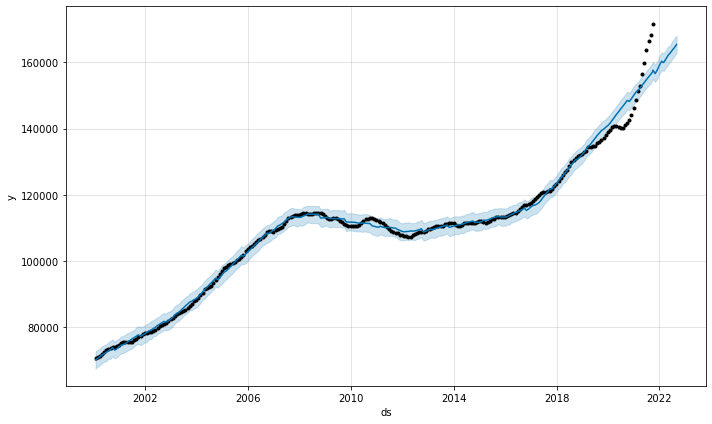

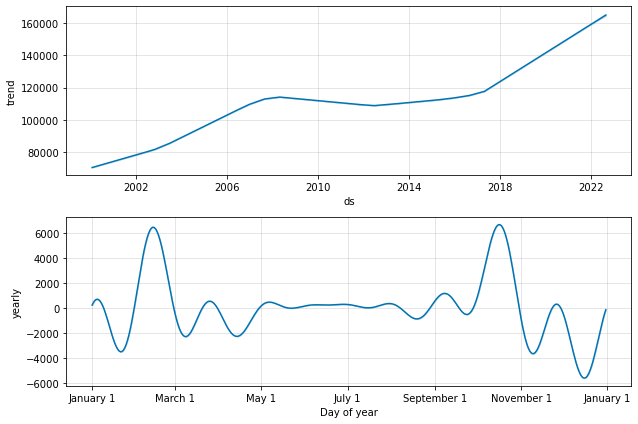

In [19]:
Facebook('Utica')

# Binghamton

In [20]:
# Binghamton ROI
Facebook_ROI('Binghamton')

3.9106660747429745

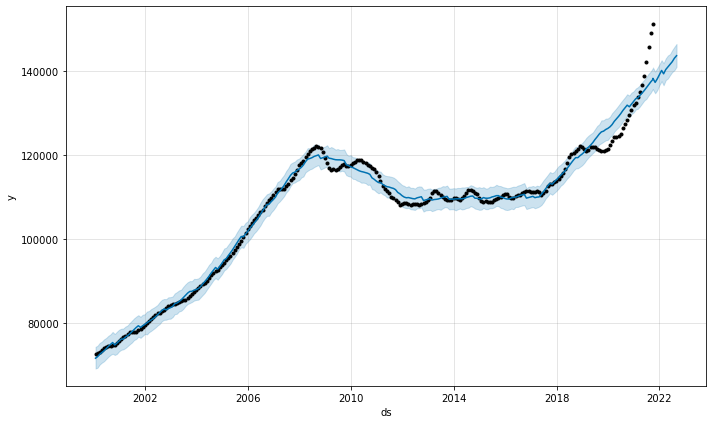

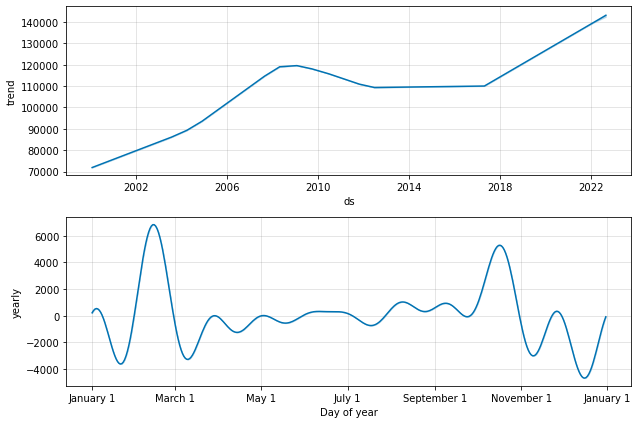

In [21]:
Facebook('Binghamton')

# Jamestown

In [22]:
#Jamestown ROI
Facebook_ROI('Jamestown')

4.968652924513004

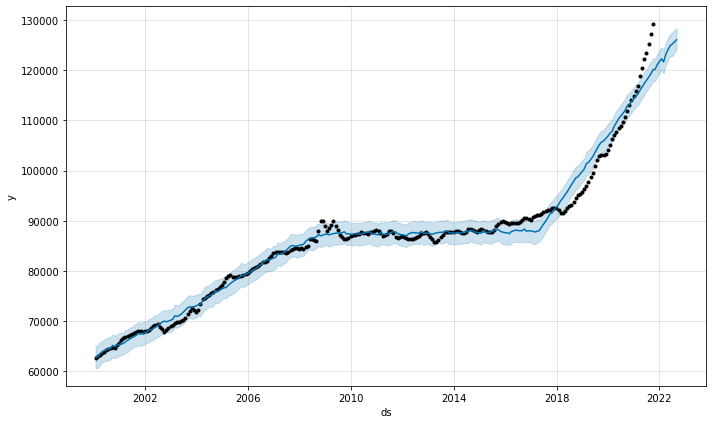

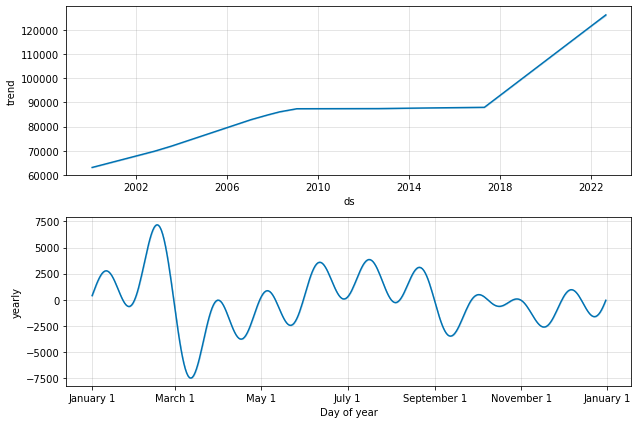

In [23]:
Facebook('Jamestown')

# Syracuse

In [24]:
#Syracuse ROI
Facebook_ROI('Syracuse')

5.142880684185434

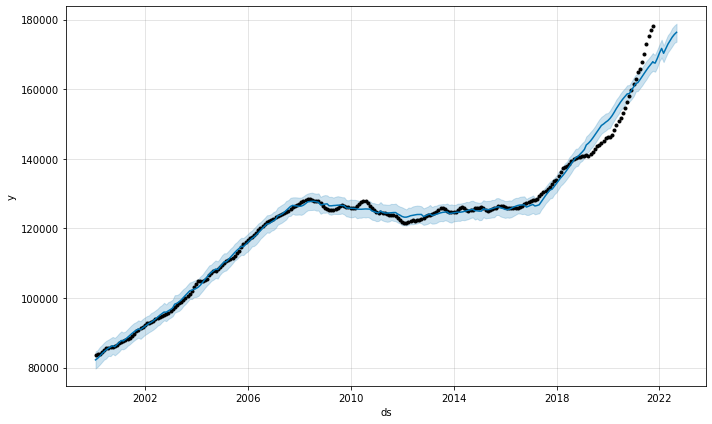

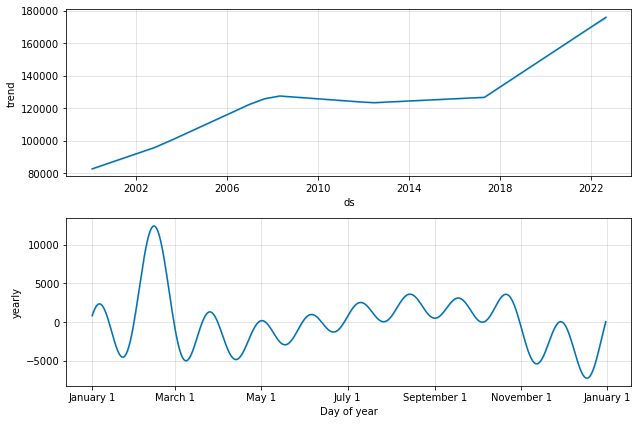

In [25]:
Facebook('Syracuse')

# Albany

In [26]:
#Albany ROI
Facebook_ROI('Albany')

4.171412863565265

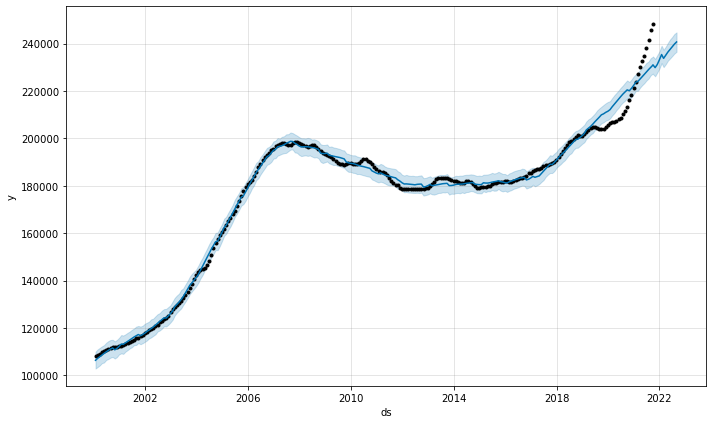

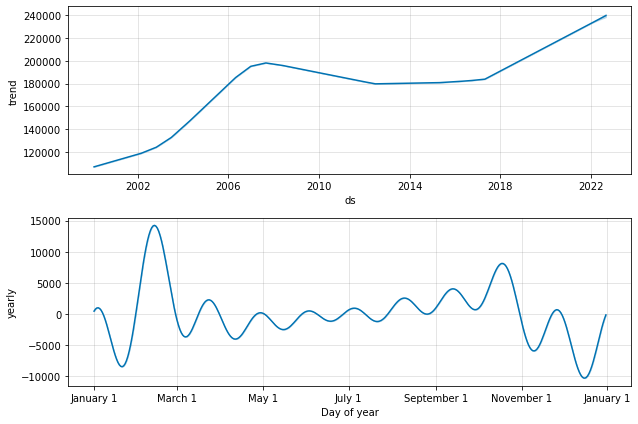

In [27]:
Facebook('Albany')

# Map Visualizations

In [28]:
#[Latitude ,Longitude]
NY = folium.Map(location=[42.849710, -75.955242],zoom_start=7.455)

tooltip = "Click me!"
folium.Marker(
    [43.100903, -75.232664], popup="<i> Utica </i>", tooltip=tooltip
).add_to(NY)
folium.Marker(
    [42.095554, -79.238609], popup="<i> Jamestown </i>", tooltip=tooltip
).add_to(NY)
folium.Marker(
    [42.098843, -75.920647], popup="<i> Binghamton </i>", tooltip=tooltip
).add_to(NY)
folium.Marker(
    [42.652580, -73.756233], popup="<i> Albany </i>", tooltip=tooltip
).add_to(NY)
folium.Marker(
    [43.088947, -76.154480], popup="<i> Syracuse </i>", tooltip=tooltip
).add_to(NY)

# Show Map
NY

- Here there are our top 5 cities to invest in on a map!!